## Finilizing Data Generation for 0D Reactor

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

pd.options.mode.chained_assignment = None  # default='warn'

from PCAfold import PCA as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_500Cases_Up/'
# TestDir    = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass

NVarsRed           = 7

tStratch           = 1.
SOLVER             = 'BDF'

ValidPerc          = 20.

FixedMinVal        = 1.e-14

POD_NAME           = '2'
iPC                = 1

if (POD_NAME == 'All'):
    NPODsFinal = 32
    PODType    = 'All'
else:
    NPODsFinal = 32
    PODType    = 'OneByOne'
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType))
except:
    pass

In [3]:
FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [4]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(100):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]]


        Flg = True
        for iPC in range(NVarsRed):
            if (np.abs( (DataTemp['PC_'+str(iPC+1)][0] - DataTemp['PC_'+str(iPC+1)][len(Data)-1])/DataTemp['PC_'+str(iPC+1)][0] ) < 1.e-4): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_PC_'+str(iPC+1) for iPC in range(NVarsRed)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data['PC_'+str(iPC+1)]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-4):
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [5]:
ICs = DataIC.to_numpy()

In [6]:
DataInput

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.067115,-0.052756,0.213152,0.070804,0.103506,0.170238,-0.026645,-0.007606,0.134463,0.129448,...,0.11023,0.146985,-0.000089,0.075616,0.097245,0.176825,0.158987,0.137815,0.037526,0.094500
1,0.067115,-0.052756,0.213152,0.070804,0.103506,0.170238,-0.026645,-0.007606,0.134463,0.129448,...,0.11023,0.146985,-0.000089,0.075616,0.097245,0.176825,0.158987,0.137815,0.037526,0.094500
2,0.067115,-0.052756,0.213152,0.070804,0.103506,0.170238,-0.026645,-0.007606,0.134463,0.129448,...,0.11023,0.146985,-0.000089,0.075616,0.097245,0.176825,0.158987,0.137815,0.037526,0.094500
3,0.067115,-0.052756,0.213152,0.070804,0.103506,0.170238,-0.026645,-0.007606,0.134463,0.129448,...,0.11023,0.146985,-0.000089,0.075616,0.097245,0.176825,0.158987,0.137815,0.037526,0.094500
4,0.067115,-0.052756,0.213152,0.070804,0.103506,0.170238,-0.026645,-0.007606,0.134463,0.129448,...,0.11023,0.146985,-0.000089,0.075616,0.097245,0.176825,0.158987,0.137815,0.037526,0.094500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.012652,-0.051895,0.040454,0.080839,0.118507,0.084308,-0.063050,0.045309,0.020572,0.015570,...,0.07156,0.105496,0.032103,0.009496,0.031159,0.119549,0.026841,0.015832,0.021901,0.066805
4996,-0.012652,-0.051895,0.040454,0.080839,0.118507,0.084308,-0.063050,0.045309,0.020572,0.015570,...,0.07156,0.105496,0.032103,0.009496,0.031159,0.119549,0.026841,0.015832,0.021901,0.066805
4997,-0.012652,-0.051895,0.040454,0.080839,0.118507,0.084308,-0.063050,0.045309,0.020572,0.015570,...,0.07156,0.105496,0.032103,0.009496,0.031159,0.119549,0.026841,0.015832,0.021901,0.066805
4998,-0.012652,-0.051895,0.040454,0.080839,0.118507,0.084308,-0.063050,0.045309,0.020572,0.015570,...,0.07156,0.105496,0.032103,0.009496,0.031159,0.119549,0.026841,0.015832,0.021901,0.066805


In [7]:
# NPODs      = 128
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# plt.figure(figsize=(8,8))
# for j, Scaling in enumerate(ScalingVec):

#     pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
#     C          = pca.X_center
#     D          = pca.X_scale
#     A          = pca.A[:,0:NPODs].T
#     L          = pca.L
#     AT         = A.T

#     plt.plot(L, label=Scaling)
    
# plt.ylim([1.e-14, 1.e0])
# plt.yscale('log')
# plt.legend()

In [8]:
# NPODsVec   = np.arange(30,150,10)
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# MaxPerc    = np.zeros((len(NPODsVec), len(ScalingVec)))
# MaxSE      = np.zeros((len(NPODsVec), len(ScalingVec)))
# MeanPerc   = np.zeros((len(NPODsVec), len(ScalingVec)))
# MSE        = np.zeros((len(NPODsVec), len(ScalingVec)))
# for i, NPODs in enumerate(NPODsVec):
#     #print('NPODs = ', NPODs)
    
#     for j, Scaling in enumerate(ScalingVec):

#         pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
#         C          = pca.X_center
#         D          = pca.X_scale
#         A          = pca.A[:,0:NPODs].T
#         L          = pca.L
#         AT         = A.T

#         yMat_pca   = ((yMat - C)/D).dot(AT)
#         yMat_      = (yMat_pca.dot(A))*D + C
        
#         MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
#         MaxSE[i,j]      = np.max((yMat - yMat_)**2)
#         MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
#         MSE[i,j]        = np.mean((yMat - yMat_)**2)

# plt.figure(figsize=(8,8))
# plt.plot(NPODsVec, MaxPerc, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Max % Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(NPODsVec, MaxSE, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Max Squared Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(NPODsVec, MeanPerc, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Mean % Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(NPODsVec, MSE, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Mean Squared Error')
# plt.legend()
# plt.yscale('log')

In [9]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [10]:
LL, SS = R_pca(yMat).fit(max_iter=3000)#tol=5.e-5)

iteration: 1, error: 0.0063158758406223715
iteration: 100, error: 0.000468478697027722
iteration: 200, error: 0.00041649595847165476
iteration: 300, error: 0.0003367787918693497
iteration: 400, error: 0.0003337867868878646
iteration: 500, error: 0.0002732601220915629
iteration: 600, error: 0.00020992948686072817
iteration: 700, error: 0.0002571639925470095
iteration: 800, error: 0.00025957799437091925
iteration: 900, error: 0.00017809737390786065
iteration: 1000, error: 0.0001656427816443263
iteration: 1100, error: 0.00017878669263466686
iteration: 1200, error: 0.00016813187356216284
iteration: 1300, error: 0.0001368258114994886
iteration: 1400, error: 0.00012454425905666328
iteration: 1500, error: 0.00011735111024465222
iteration: 1600, error: 0.00014642331132602078
iteration: 1700, error: 0.00015026574281594294
iteration: 1800, error: 0.00011752230661185273
iteration: 1900, error: 0.00010900736869117387
iteration: 2000, error: 0.00011870690948985781
iteration: 2100, error: 0.00014006

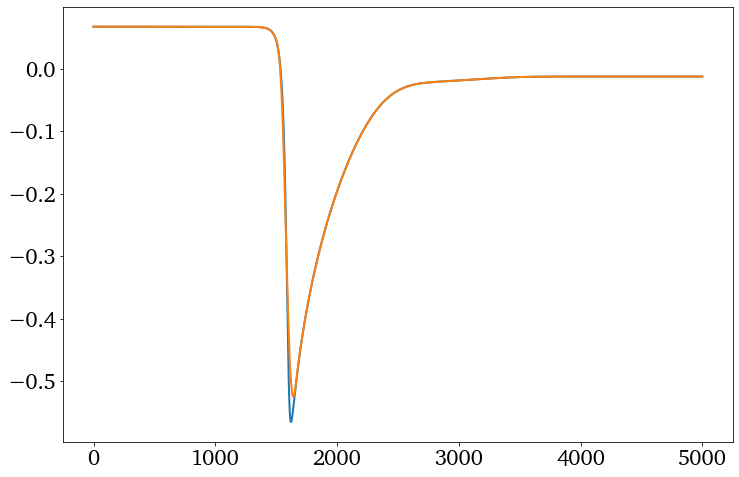

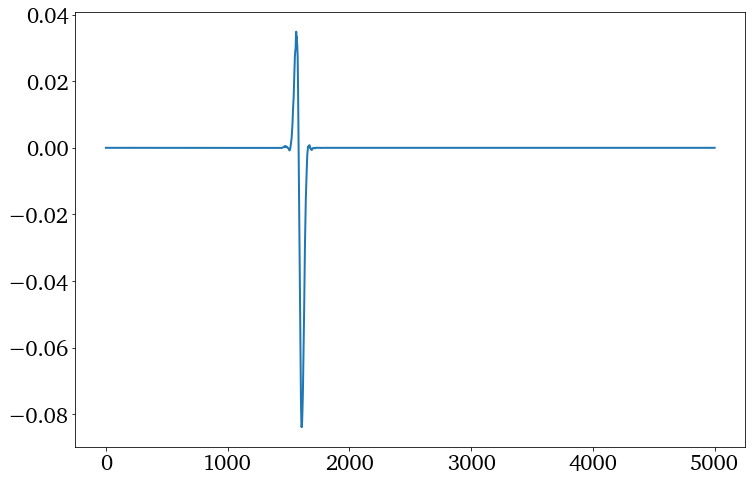

In [11]:
iVar = 0

fig = plt.figure(figsize=(12,8))
plt.plot(yMat[:,iVar])
plt.plot(LL[:,iVar])


fig = plt.figure(figsize=(12,8))
plt.plot(SS[:,iVar])

In [43]:
NPODsFinal = 60

pca        = PCAA(yMat, scaling='none', n_components=NPODsFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODsFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (60, 500)
[PCA] 


In [44]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (5000, 60)
[PCA]  Max % Error =  344514.88347921957
[PCA]  Max      SE =  0.009473444758948719
[PCA] Mean % Error =  2.293459584112575
[PCA]          MSE =  1.0671624510044092e-06


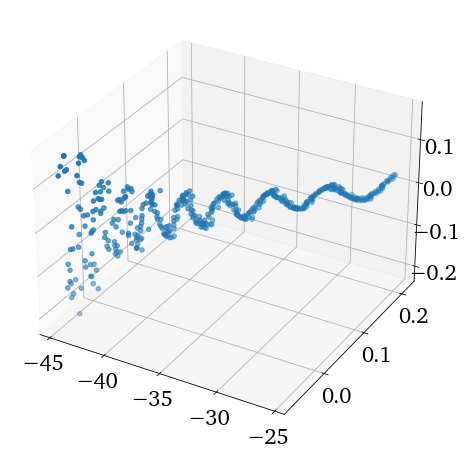

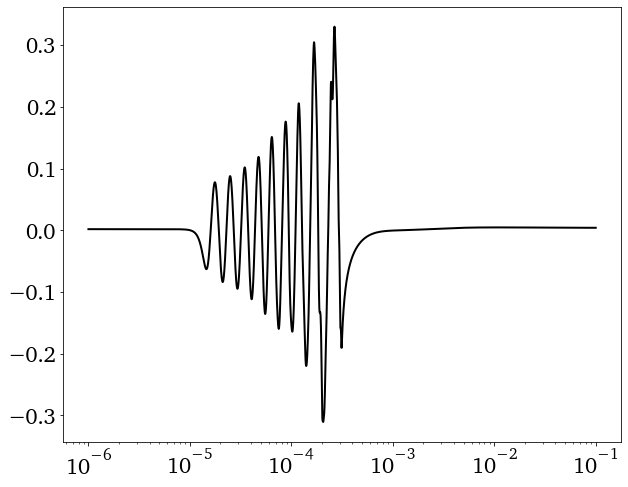

In [45]:
iVar    = 19

Eta_1   = DataIC.to_numpy()[:,0]
Eta_2   = DataIC.to_numpy()[:,1]
Alpha_1 = A[iVar,:]

fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(projection='3d')
ax.scatter(Eta_1, Eta_2, Alpha_1)

plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

In [46]:
NPODsFinal = 40

pca        = PCAA(LL, scaling='pareto', n_components=NPODsFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODsFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (40, 500)
[PCA] 


In [47]:
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

In [48]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((LL - C)/D).dot(AT)

LL_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((LL - LL_)/LL)*100))
print('[PCA]  Max      SE = ', np.max((LL - LL_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((LL - LL_)/LL)*100))
print('[PCA]          MSE = ', np.mean((LL - LL_)**2))

yMat_    = LL_ + SS
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (5000, 40)
[PCA]  Max % Error =  30730.09047452999
[PCA]  Max      SE =  3.5777645727409026e-08
[PCA] Mean % Error =  0.16019252270207016
[PCA]          MSE =  7.867144726302493e-10
[PCA]  Max % Error =  30546.19481592379
[PCA]  Max      SE =  3.5777645727409026e-08
[PCA] Mean % Error =  0.15805305172390166
[PCA]          MSE =  7.867186159827896e-10


In [49]:
# #%matplotlib qt

# iVar    = 2

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')

In [50]:
A[:,0].shape

(40,)

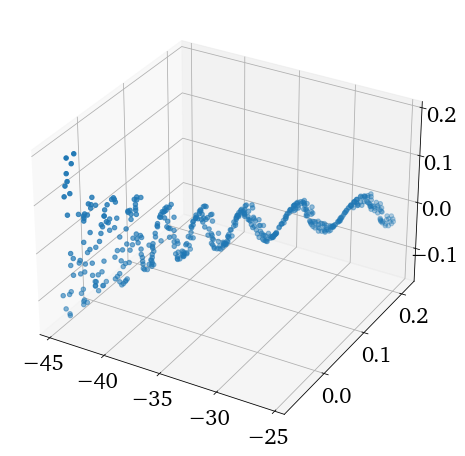

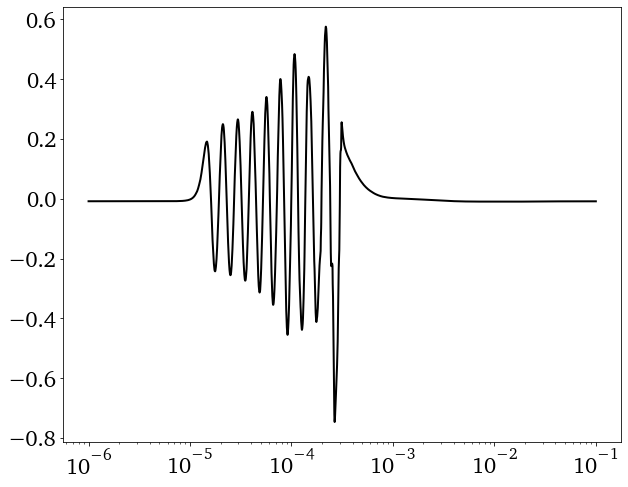

In [51]:
iVar    = 19

Eta_1   = DataIC.to_numpy()[:,0]
Eta_2   = DataIC.to_numpy()[:,1]
Alpha_1 = A[iVar,:]

fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(projection='3d')
ax.scatter(Eta_1, Eta_2, Alpha_1)

plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

(1e-06, 0.1)

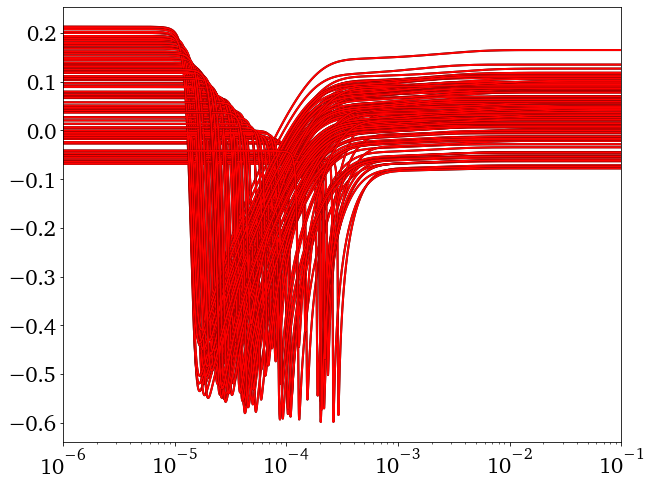

In [52]:
iVarVec = np.arange(100)#[10, 20, 30, 40]

plt.figure(figsize=(10,8))
for iVar in iVarVec:
    plt.plot(tVec, yMat[:,iVar], '-k')
    plt.plot(tVec, yMat_[:,iVar], '-r')
plt.xscale('log')
plt.xlim([1.e-6,1.e-1])

In [53]:
Vars             = ['POD_'+str(iPOD+1) for iPOD in range(NPODsFinal)]
Data             = pd.DataFrame(yMat_pca, columns=Vars)
tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

,POD_1,POD_2,POD_3,POD_4,POD_5,POD_6,POD_7,POD_8,POD_9,POD_10,...,POD_34,POD_35,POD_36,POD_37,POD_38,POD_39,POD_40,t,log(t),log10(t)
0,-5.061061,-0.515939,-0.153488,0.10025,2.041467,-0.369664,0.203890,0.209870,-0.162276,0.020073,...,-0.000159,-0.000364,-0.000981,0.000184,0.000745,0.000245,0.000273,0.000001,-13.815511,-6.000000
1,-5.061060,-0.515939,-0.153488,0.10025,2.041467,-0.369664,0.203890,0.209870,-0.162276,0.020073,...,-0.000159,-0.000364,-0.000981,0.000184,0.000745,0.000245,0.000273,0.000001,-13.813208,-5.999000
2,-5.061060,-0.515939,-0.153488,0.10025,2.041467,-0.369664,0.203890,0.209870,-0.162276,0.020073,...,-0.000159,-0.000364,-0.000981,0.000184,0.000745,0.000245,0.000273,0.000001,-13.810904,-5.998000
3,-5.061060,-0.515939,-0.153488,0.10025,2.041467,-0.369664,0.203890,0.209870,-0.162276,0.020072,...,-0.000159,-0.000364,-0.000981,0.000184,0.000745,0.000245,0.000273,0.000001,-13.808601,-5.996999
4,-5.061060,-0.515939,-0.153488,0.10025,2.041467,-0.369664,0.203890,0.209870,-0.162276,0.020072,...,-0.000159,-0.000364,-0.000981,0.000184,0.000745,0.000245,0.000273,0.000001,-13.806298,-5.995999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.967759,0.671066,-0.808450,0.14185,-1.237935,-0.183496,-0.267867,0.102011,0.127552,0.106572,...,0.007010,-0.005387,0.000175,-0.000287,0.000009,0.003143,-0.000437,0.099083,-2.311797,-1.004001
4996,-1.967759,0.671066,-0.808450,0.14185,-1.237935,-0.183496,-0.267867,0.102011,0.127552,0.106572,...,0.007010,-0.005387,0.000175,-0.000287,0.000009,0.003143,-0.000437,0.099311,-2.309494,-1.003001
4997,-1.967759,0.671066,-0.808450,0.14185,-1.237935,-0.183496,-0.267867,0.102011,0.127552,0.106572,...,0.007010,-0.005387,0.000175,-0.000287,0.000009,0.003143,-0.000437,0.099540,-2.307191,-1.002000
4998,-1.967759,0.671066,-0.808450,0.14185,-1.237936,-0.183496,-0.267867,0.102011,0.127552,0.106572,...,0.007010,-0.005387,0.000175,-0.000287,0.000009,0.003143,-0.000437,0.099770,-2.304888,-1.001000


In [54]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/')
except:
    pass

In [55]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [56]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [57]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
except:
    pass

In [58]:
OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'

'/Users/sventur/WORKSPACE//ROMNet/Data/0DReact_Isobaric_500Cases_Up//7PC/OneByOne/POD_2/Branch/train/'

In [59]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [60]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Output.csv', index=False)

In [61]:
# NComp = 2

# pca        = PCAA(ICs, scaling='none', n_components=NComp)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:NComp].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [62]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# ICs_pca   = ((ICs - C)/D).dot(AT)

# ICs_      = (ICs_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', ICs_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]  Max      SE = ', np.max((ICs - ICs_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]          MSE = ', np.mean((ICs - ICs_)**2))

In [63]:
# A